In [46]:
import re
import os
import cv2
import time
import random
import plotly.express as px
from tqdm import tqdm
from scipy import signal
import scipy as sp
import scipy.ndimage
import numpy as np
import typing as t
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as k
from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model, Model
from joblib import Parallel, delayed
from skimage.transform import resize
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier

import config as c
from utils.image_processing import crop_image
import utils.model as model_factory
from utils.dataset import get_train_data, get_test_data

plt.rcParams["figure.figsize"] = (10, 10)

In [47]:
df = get_train_data(available_energy_values=[1, 3, 6, 10, 20, 30], input_shape=(250, 250), values_linear_transformation=False, center_by_max=False, short_load=False, distance_matrices=False, return_as_dataframe=True)

100%|██████████| 6758/6758 [00:00<00:00, 28880.26it/s]


## В чем особенность данных, или почему сверточные сети нам не помогут?

Прежде всего стоит вспомнить, что мы работаем с проекциями 3-х мерных результатов реакций взаимодействия высокоэнергетической частицы на плоскость. Об этом говорится в видео-лекции по соревнованию, да и в описании соревнования об этом есть информация. Нам нужно классифицировать изображения на 2 класса видов частиц и на 3 класса энергий.

Если не вдаваться в детали процесса формирования изображения, то пятно сформировано из нескольких тысяч точек/фотонов, положение которых определяется нормальным случайным распределением, а значения ‘яркости’ геометрическим распределением (причем сумма их яркостей равна энергии изначальной частицы). Эти точки суммируются попиксельно и формируют пятно. (Может показаться, что изображения с ER 10, 20 и 30 имеют другую природу, но на самом деле там просто пятно размазано по треку).

Важно отметить, что сам процесс взаимодействия частицы с веществом по большей части случаен, а значит и результат взаимодействия в виде изображения сохранит в себе эту случайность. Форма пятна (его радиус) и скорость падения 'яркости' от центра пятна к краям не случайны и зависят от типа частицы, яркость зависит от типа энергии частицы, но вот распределение позиций точек в пятне и их энергии абсолютно случайно.

И может показаться что все предельно просто, и для определения типа частицы достаточно ее радиус посчитать, а для энергии и вовсе просто просуммировать пиксели пятна, вычев из них шум. И да, применив примитивную фильтрацию и сложив яркости пикселей в ядре действительно получается очень точно определять энергию частицы (точность  классификации 100%). Однако есть проблема с определением типа частицы. Очень легко можно выделить частицы с длинным треком или даже просто со смещением от центра, а так-как смещение есть только у ER 10, 20, 30 определение их класса не является проблемой. Но вот отличить частицы ER 1 и 3 от NR 1, 3, 6 вызывает проблемы (точность по roc_auc_score=0.9993, а этого недостаточно, нужно 1). Причина как раз в том, что имея столь малую суммарную энергию шумы начинают вносить серьезную ошибку в определение параметров пятна. 

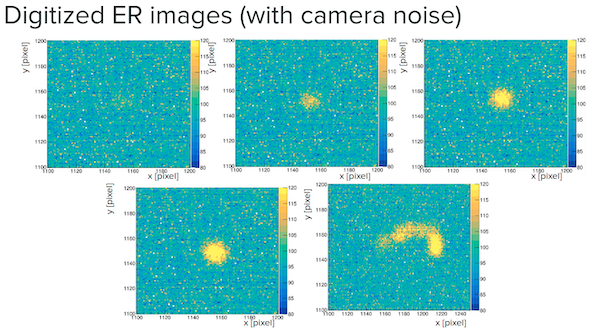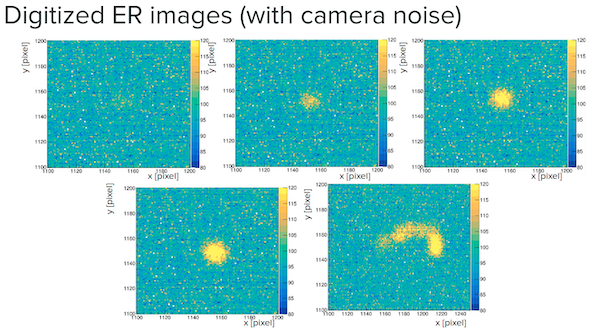

## Как происходит определение параметров пятна для последующей классификации?

Прежде всего нужно уточнить, что речь идет о классификации именно круглых пятен, так как треки можно без проблем классифицировать и без определения их характеристик. Итак, у нас есть два вида пятен, и по изображению без шума снизу можно легко заметить, что они немного отличаются размерами и, что более важно, скоростью снижения яркости от ценра пятна к краям:

<img src="https://sun9-75.userapi.com/impg/rct1X8uxi_bmR6jXHIavCguEUb_NXgwoj6sb_Q/u_eEM5KYVkY.jpg?size=2508x1270&quality=96&sign=e98d3e51e8bc4127036e7ece9cb08018&type=album" alt="Drawing" style="width: 800px;"/>
<img src="https://sun9-22.userapi.com/impg/Y6WxqctcEZVnpxfRmryUtxgQkdb06s18ueuDSA/goJOBKM7UI0.jpg?size=2524x1253&quality=96&sign=1edc69bce60922d5f37b19911ea5411c&type=album" alt="Drawing" style="width: 800px;"/>

Именно эти характеристики я и пытаюсь выделить с помощью функции get_height_map. В ней изображение разрезается на 30 фрагментов, в виде кругов разного радиуса, и для каждого из них считается среднее значение. Таким образом я получаю что-то вроде топографической карты высот, но так как мы знаем, что пятно - это круг, вместо 2d карты у нас график изменения средней высоты для каждого из значений радиуса.



<img src="https://image.freepik.com/free-vector/topographic-map-background-of-mountain-terrain-vector-mapping-contour-texture-with-elevation_53562-7903.jpg" alt="Drawing" style="width: 600px;"/>

In [48]:
def create_circular_mask(h, w, center=None, radius=None):
    # Создает круговую маску изображения, с требуемым радиусом
    if center is None:
        center = (int(w/2), int(h/2))
    if radius is None:
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def get_height_map(img):
    # Получает граффик высот пятна
    m = np.zeros((15))
    for r in range(0, 30, 2):
        mask = create_circular_mask(80, 80, radius=r) * (~create_circular_mask(80, 80, radius=r-2))
        m[r//2] = np.sum(mask * (img-100.4)) / np.sum(mask)
    m -= m.min()
    m /= m.max()
    m = np.gradient(m)
    return m


def get_histogram_map(img, radius_0=7, radius_1=30):
    mask = create_circular_mask(80, 80, radius=radius_1) * (~create_circular_mask(80, 80, radius=radius_0))
    m = np.histogram(img[mask], range=(100, 120), bins=20)[0]
    
    return m

def get_img_spector(img):
    sum_img = np.sum(img*create_circular_mask(80, 80, radius=20)).reshape(-1)
    std_img = np.std(img*create_circular_mask(80, 80, radius=20)).reshape(-1)
    
    histogram_map_0_7 = get_histogram_map(img, 0, 6)
    histogram_map_7_30 = get_histogram_map(img, 6, 30)
    img = sp.ndimage.filters.gaussian_filter(img, [5.0, 5.0])
    
    height_map = get_height_map(img)
    spector = np.concatenate([histogram_map_0_7, histogram_map_7_30, height_map, sum_img, std_img])
    #spector = np.concatenate([np.array(kurtosis(height_map)).reshape(-1), sum_img, std_img])
    
    #spector = np.concatenate([std_img, np.array(kurtosis(height_map)).reshape(-1), sum_img])
    return spector

def get_circular_ratio(img):
    img_gaussian = sp.ndimage.filters.gaussian_filter(img.copy(), [3.0, 3.0])
    gaussian_mask = img_gaussian > np.quantile(img_gaussian, 0.995)
    r = np.sqrt(np.sum(gaussian_mask)/np.pi)
    mask = create_circular_mask(250, 250, radius=r)
    return np.sum(mask*gaussian_mask)/np.sum(mask+gaussian_mask)

def get_bright_sum(img):
    img_gaussian = sp.ndimage.filters.gaussian_filter(img.copy(), [3.0, 3.0])
    gaussian_mask = img_gaussian > np.quantile(img_gaussian, 0.98)#112
    return np.sum(img[gaussian_mask]-100.4)/1000

### Пример масок изображения, по которым идет усреднение высоты:

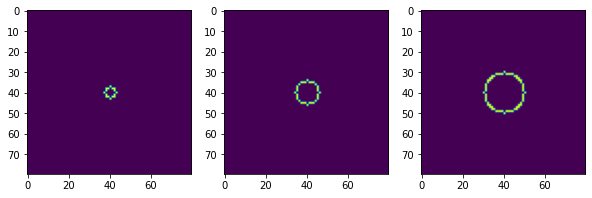

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(create_circular_mask(80, 80, radius=3) * (~create_circular_mask(80, 80, radius=2)))
ax2.imshow(create_circular_mask(80, 80, radius=6) * (~create_circular_mask(80, 80, radius=5)))
ax3.imshow(create_circular_mask(80, 80, radius=10) * (~create_circular_mask(80, 80, radius=9)))
plt.show()

### Результаты работы функции get_height_map для частиц ER3 и NR6
Как можно заметить, после сглаживания изображения, для минимизации шумов и нормализации по максимуму частицы дают достаточно сильно отличающиеся графики изменения высоты от центра к краю пятна.

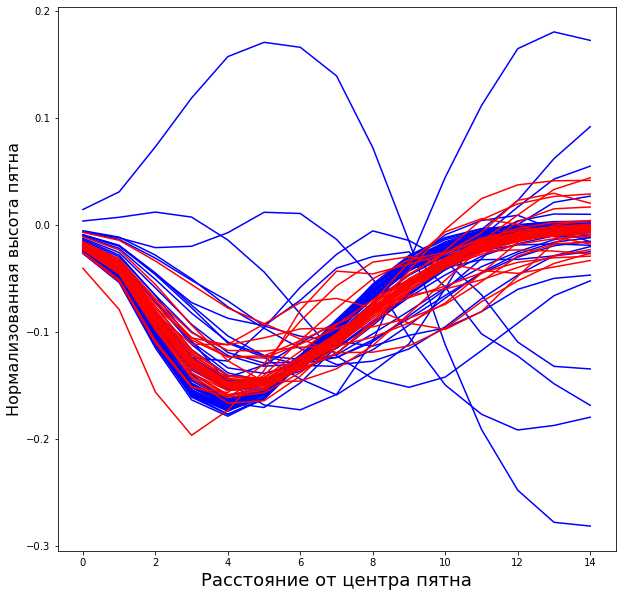

In [50]:
for i in range(50):
    img = crop_image(df[(df.t==0)]['img_250'].iloc[i], (80, 80), False)
    img = sp.ndimage.filters.gaussian_filter(img, [5.0, 5.0])
    m = get_height_map(img)
    #m = np.gradient(m)
    #m = np.gradient(m)
    #print(kurtosis(m))
    plt.plot(m, color='b')
    

for i in range(50):
    img = crop_image(df[(df.t==1)]['img_250'].iloc[i], (80, 80), False)
    img = sp.ndimage.filters.gaussian_filter(img, [5.0, 5.0])
    m = get_height_map(img)
    #m = np.gradient(m)
    #m = np.gradient(m)
    #print(kurtosis(m))
    plt.plot(m, color='r')

plt.xlabel('Расстояние от центра пятна', fontsize=18)
plt.ylabel('Нормализованная высота пятна', fontsize=16)
plt.show()

In [51]:
m = get_height_map(img)
from scipy.stats import norm, kurtosis
kurtosis(np.gradient(m))

-0.879046613038537

In [52]:
get_img_spector(img)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.00000000e+00,  8.00000000e+00,
        1.45000000e+03,  3.27000000e+02,  1.74000000e+02,  1.16000000e+02,
        9.00000000e+01,  6.80000000e+01,  5.60000000e+01,  5.50000000e+01,
        4.90000000e+01,  3.60000000e+01,  4.50000000e+01,  2.80000000e+01,
        3.60000000e+01,  2.10000000e+01,  3.50000000e+01,  1.60000000e+01,
        3.00000000e+01,  2.00000000e+01,  2.10000000e+01,  7.00000000e+00,
       -1.36383079e-02, -2.82387899e-02, -6.36166390e-02, -9.80364888e-02,
       -1.21293837e-01, -1.29076051e-01, -1.24216285e-01, -1.14445567e-01,
       -9.63223187e-02, -7.55344949e-02, -5.64074224e-02, -3.84450058e-02,
       -2.51945048e-02, -

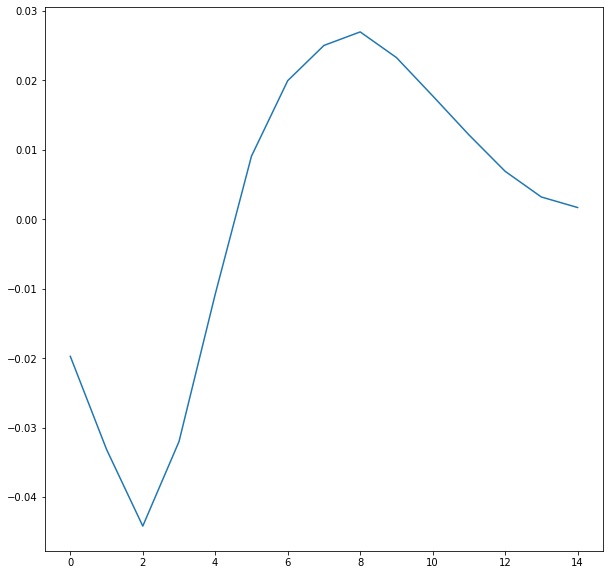

In [53]:
plt.plot(np.gradient(m))

### Далее нужно определить circular_ratio и bright_sum

circular_ratio - коэффициент, определяющий какой процент пикселей пятна находятся внутри окружности, очень хорошо выделяет все пятна размазанные по треку.

bright_sum - сумма пикселей внутри пятна, позволяет дать примерную оценку энергии пятна.

In [54]:
df['circular_ratio'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_ratio)(img) for img in tqdm(df['img_250'])))
df['bright_sum'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_bright_sum)(img) for img in tqdm(df['img_250'])))
df.head()

100%|██████████| 13404/13404 [00:06<00:00, 2119.03it/s]


,t,e,img_250,circular_ratio,bright_sum
0,1,6,"[[105.0, 100.0, 96.0, 103.0, 99.0, 103.0, 103....",0.884146,3.486998
1,1,20,"[[106.0, 97.0, 98.0, 101.0, 101.0, 101.0, 104....",0.925234,10.607998
2,1,20,"[[104.0, 101.0, 98.0, 99.0, 103.0, 105.0, 101....",0.913313,9.111998
3,1,20,"[[95.0, 104.0, 101.0, 99.0, 103.0, 100.0, 98.0...",0.919255,10.104999
4,1,20,"[[95.0, 100.0, 94.0, 98.0, 98.0, 99.0, 95.0, 1...",0.878419,12.223998


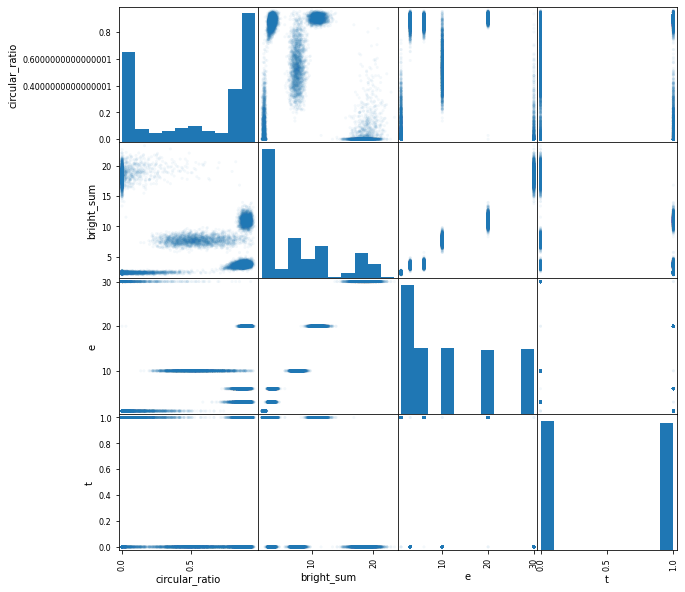

In [55]:
scatter_matrix(df[['circular_ratio', 'bright_sum', 'e', 't']], alpha=0.05, figsize=(10, 10));

#### Далее отделяем пятна, которые слишком сильно смещены от центра, и при этом достаточно яркие, чтобы это смещение не было случайным шумом:

In [58]:
df_center_shifted = df[((df.circular_ratio<0.8)&(df.bright_sum>5))]
df = df[~((df.circular_ratio<0.8)&(df.bright_sum>5))]

Здесь хорошо видно, что для классификации пятен (с треками) по энергии уже не нужно никаких дополнительных действий:

C:\Users\Kirill\anaconda3\lib\site-packages\ipykernel\pylab\backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


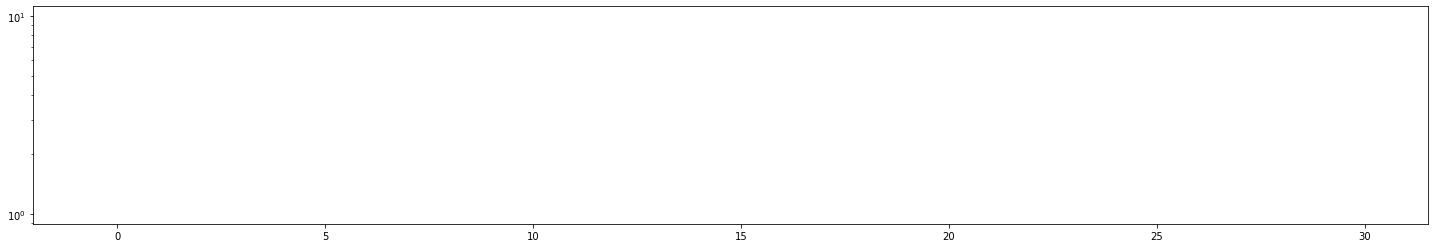

In [59]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(df_center_shifted.bright_sum[df_center_shifted.e==10], bins=50, alpha=0.5, range=(-0.5, 30), log=True)
plt.hist(df_center_shifted.bright_sum[df_center_shifted.e==30], bins=50, alpha=0.5, range=(-0.5, 30), log=True)
plt.show()

#### Для оставшихся изображений производим обрезку по центру до 80 пикселей, так-как все оставшиеся пятна не имеют больше смещения. И сразу находим ‘спектр’ (характеристики) этих пятен.

In [60]:
df['img_80'] = Parallel(n_jobs=c.NUM_CORES)(delayed(crop_image)(img, (80, 80), False) for img in tqdm(df['img_250']))
df['img_80'] = df['img_80'].map(lambda img: img-np.mean((img[:25]+img[-25:]), axis=0).reshape(1, 80)/2+100.4)
df['spector'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(df['img_80']))

100%|██████████| 9028/9028 [00:22<00:00, 400.46it/s]


In [61]:
df['std'] = df['spector'].map(lambda spector: spector[0])
df['sum'] = df['spector'].map(lambda spector: spector[2])
df['kurtosis'] = df['spector'].map(lambda spector: spector[1])

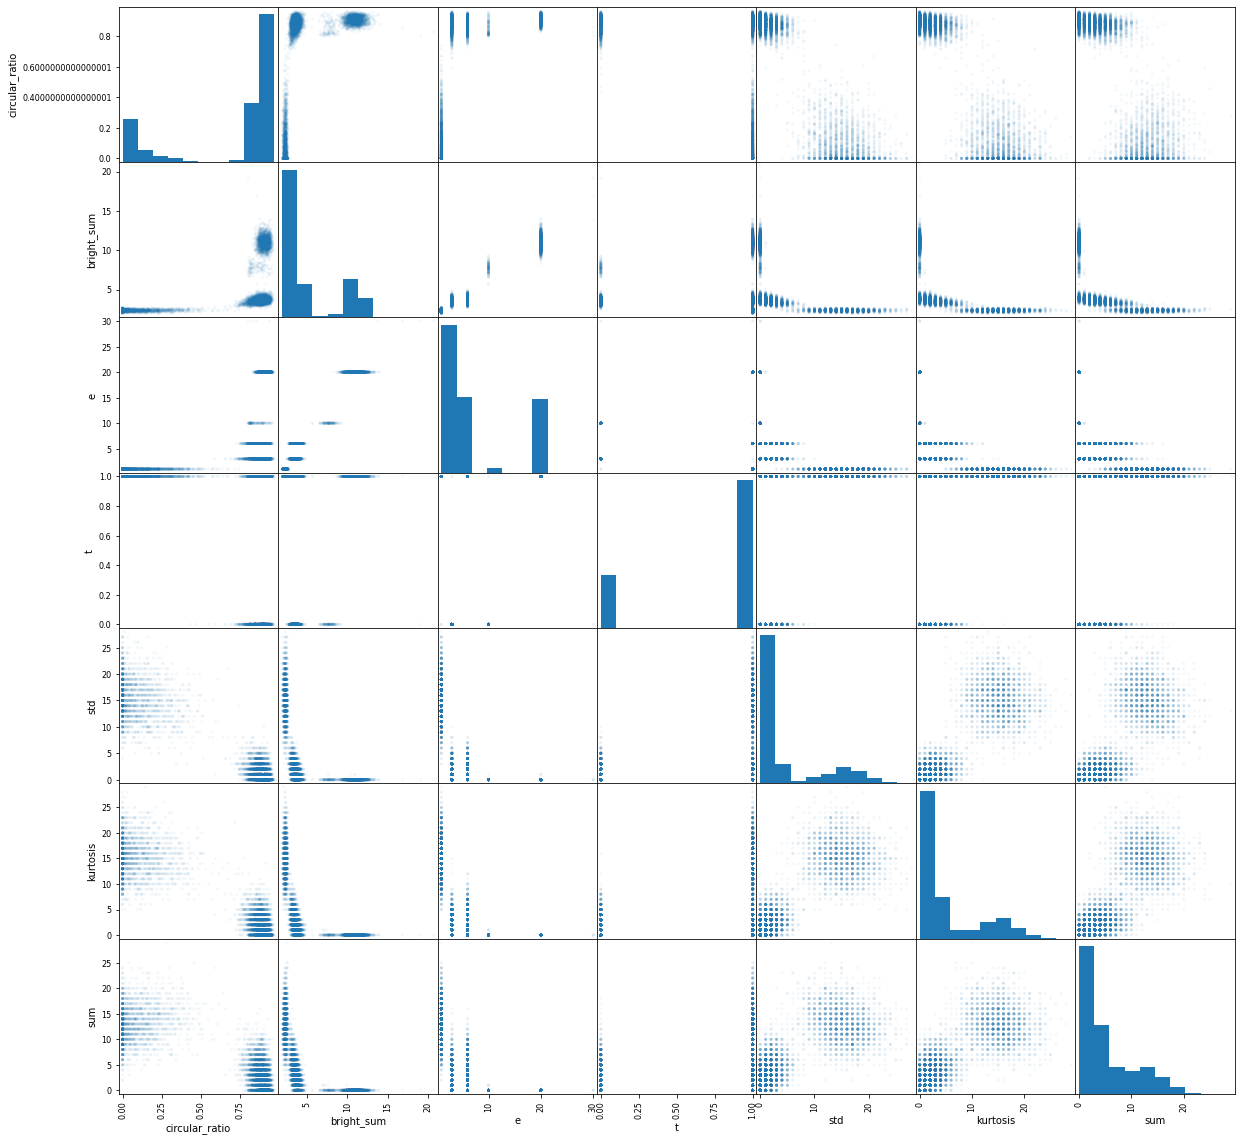

In [62]:
scatter_matrix(df[['circular_ratio', 'bright_sum', 'e', 't', 'std', 'kurtosis', 'sum']], alpha=0.05, figsize=(20, 20));

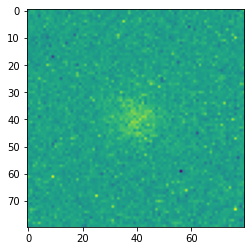

In [63]:
plt.imshow(df['img_80'].iloc[0])

In [64]:
df.head()

,t,e,img_250,circular_ratio,bright_sum,img_80,spector,std,sum,kurtosis
0,1,6,"[[105.0, 100.0, 96.0, 103.0, 99.0, 103.0, 103....",0.884146,3.486998,"[[93.04, 105.14, 104.98, 99.520004, 99.14, 104...","[1.0, 1.0, 3.0, 3.0, 2.0, 7.0, 9.0, 14.0, 12.0...",1.0,3.0,1.0
1,1,20,"[[106.0, 97.0, 98.0, 101.0, 101.0, 101.0, 104....",0.925234,10.607998,"[[100.380005, 100.200005, 102.36, 97.5, 97.62,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0
2,1,20,"[[104.0, 101.0, 98.0, 99.0, 103.0, 105.0, 101....",0.913313,9.111998,"[[101.14, 101.880005, 102.6, 100.94, 100.92, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0.0,0.0,0.0
3,1,20,"[[95.0, 104.0, 101.0, 99.0, 103.0, 100.0, 98.0...",0.919255,10.104999,"[[96.26, 100.5, 95.42, 97.18, 99.68, 101.42, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0
4,1,20,"[[95.0, 100.0, 94.0, 98.0, 98.0, 99.0, 95.0, 1...",0.878419,12.223998,"[[98.82, 107.0, 98.66, 102.44, 101.46, 99.54, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0


### Попробуем классифицировать пятна по имеющимся фичам

In [72]:
#x = np.concatenate([df['spector'].to_numpy().tolist(), df[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
x = np.concatenate([df['spector'].to_numpy().tolist()], axis=1)
y = df.t.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=41)

In [73]:
particle_types_model = CatBoostClassifier(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

particle_types_model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(roc_auc_score(particle_types_model.predict(x_train), y_train), roc_auc_score(particle_types_model.predict(x_test), y_test))

0.9996563573883162 0.9992559523809523


In [74]:
particle_types_model = LinearRegression().fit(x_train, y_train)
particle_types_model.score(x_train, y_train)


print(roc_auc_score(particle_types_model.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model.predict(x_test)>0.5, y_test))

0.9829502513141666 0.9765359690920905


In [75]:
particle_types_model = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

particle_types_model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(roc_auc_score(particle_types_model.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model.predict(x_test)>0.5, y_test))

0.9997477295660948 0.9992559523809523


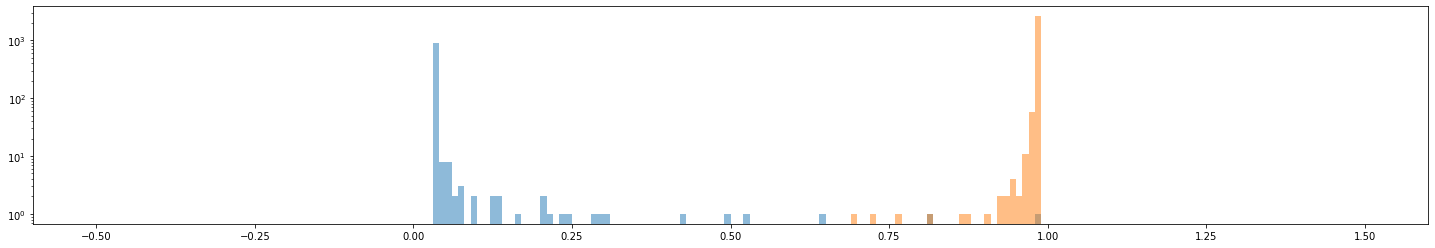

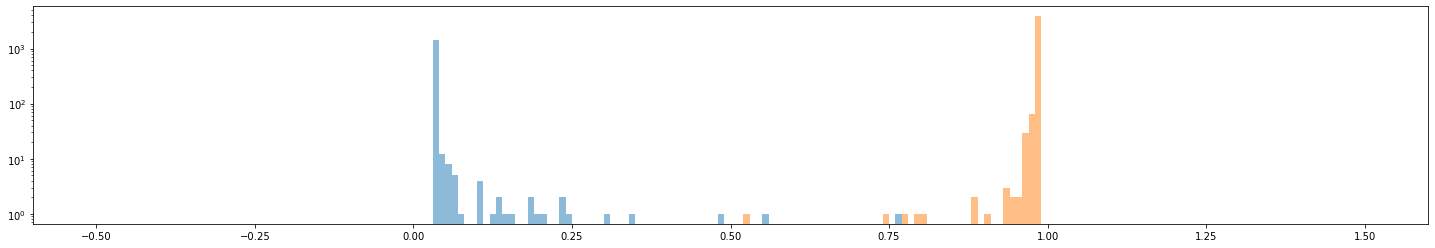

In [76]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(particle_types_model.predict(x_test[y_test.reshape(-1)==0]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model.predict(x_test[y_test.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

plt.hist(particle_types_model.predict(x_train[y_train.reshape(-1)==0]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model.predict(x_train[y_train.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

In [77]:
df['predict'] = particle_types_model.predict(x)
df['particle_types_predict'] = (particle_types_model.predict(x)>0.5)*1

In [78]:
df[df.t!=df.particle_types_predict]#.head()

,t,e,img_250,circular_ratio,bright_sum,img_80,spector,std,sum,kurtosis,predict,particle_types_predict
6816,0,3,"[[97.0, 101.0, 100.0, 100.0, 101.0, 101.0, 98....",0.828402,2.988998,"[[100.68, 98.26, 100.32, 107.94, 105.74, 99.68...","[5.0, 6.0, 5.0, 5.0, 11.0, 13.0, 10.0, 6.0, 8....",5.0,5.0,6.0,0.550019,1
11077,0,1,"[[103.0, 99.0, 99.0, 98.0, 96.0, 102.0, 102.0,...",0.548872,2.636998,"[[103.14, 107.28, 97.72, 104.16, 108.36, 99.5,...","[8.0, 10.0, 14.0, 13.0, 17.0, 11.0, 8.0, 2.0, ...",8.0,14.0,10.0,0.818137,1
11269,0,1,"[[95.0, 100.0, 100.0, 98.0, 99.0, 102.0, 95.0,...",0.433875,2.663998,"[[102.6, 95.8, 100.18, 104.700005, 100.26, 102...","[6.0, 16.0, 18.0, 10.0, 6.0, 5.0, 10.0, 4.0, 9...",6.0,18.0,16.0,0.643471,1
11610,0,3,"[[93.0, 98.0, 104.0, 107.0, 98.0, 101.0, 94.0,...",0.861446,2.929998,"[[96.700005, 102.700005, 100.62, 97.560005, 11...","[3.0, 3.0, 8.0, 8.0, 11.0, 14.0, 9.0, 8.0, 5.0...",3.0,8.0,3.0,0.529777,1
12858,0,30,"[[104.0, 100.0, 91.0, 100.0, 97.0, 100.0, 95.0...",0.828402,20.727000,"[[99.22, 99.880005, 100.200005, 100.96, 99.560...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.986410,1
13403,0,1,"[[96.0, 100.0, 101.0, 99.0, 103.0, 104.0, 102....",0.467933,2.458998,"[[101.04, 98.82, 97.04, 96.04, 104.86, 102.14,...","[9.0, 9.0, 17.0, 15.0, 14.0, 8.0, 4.0, 4.0, 5....",9.0,17.0,9.0,0.768476,1


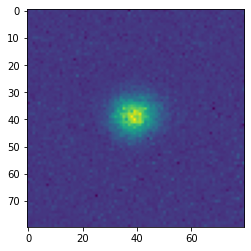

In [79]:
plt.imshow(df['img_80'][8251])

In [80]:
df[(df.t==0)&(df.e==30)]

,t,e,img_250,circular_ratio,bright_sum,img_80,spector,std,sum,kurtosis,predict,particle_types_predict
8251,0,30,"[[104.0, 103.0, 98.0, 101.0, 102.0, 99.0, 100....",0.801749,19.115,"[[97.96, 103.28, 104.72, 98.6, 109.86, 103.26,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.344362,0
12858,0,30,"[[104.0, 100.0, 91.0, 100.0, 97.0, 100.0, 95.0...",0.828402,20.727,"[[99.22, 99.880005, 100.200005, 100.96, 99.560...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.986410,1


In [81]:
df[(df.t==1)&(df.e==30)]

,t,e,img_250,circular_ratio,bright_sum,img_80,spector,std,sum,kurtosis,predict,particle_types_predict
3152,1,30,"[[101.0, 102.0, 100.0, 103.0, 98.0, 94.0, 98.0...",0.937304,13.763999,"[[103.58, 96.14, 100.880005, 92.64, 104.64, 99...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.986410,1
4368,1,30,"[[105.0, 101.0, 94.0, 99.0, 101.0, 103.0, 103....",0.855856,16.846000,"[[100.46, 103.92, 98.76, 101.66, 95.020004, 98...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.986406,1


#### Далее классифицируем оба вида частиц по энергиям отдельно, как можно заметить классификация очень точная.


In [65]:
df_t0 = df[df.t==0]
df_t0=df_t0[df_t0.e.isin([3, 10, 30])]

x = np.concatenate([df_t0['spector'].to_numpy().tolist(), df_t0[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
y = df_t0.e.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [66]:
energies_model_t0 = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

energies_model_t0.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(mean_absolute_error(energies_model_t0.predict(x_train), y_train), mean_absolute_error(energies_model_t0.predict(x_test), y_test))

0.07823944226216495 0.07142686871851261


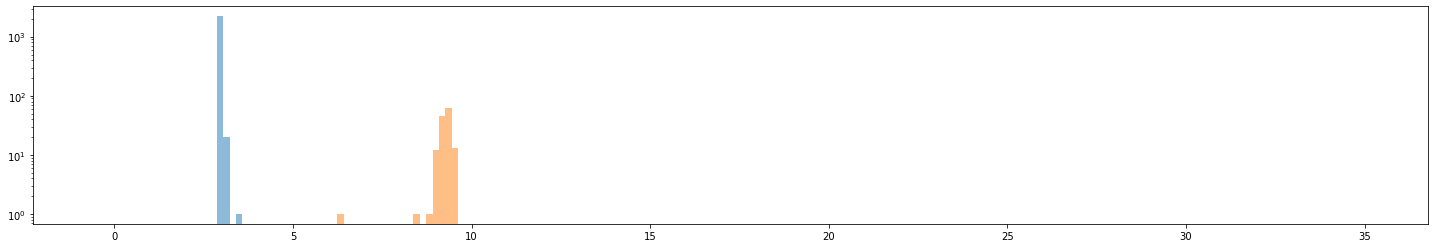

In [67]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(energies_model_t0.predict(x[y.reshape(-1)==3]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.hist(energies_model_t0.predict(x[y.reshape(-1)==10]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
#plt.hist(energies_model_t0.predict(x[y.reshape(-1)==30]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.show()

Классификация по энергиям частиц NR:

In [68]:
df_t0 = df[df.t==1]
df_t0=df_t0[df_t0.e.isin([1, 6, 20])]

x = np.concatenate([df_t0['spector'].to_numpy().tolist(), df_t0[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
y = df_t0.e.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [69]:
energies_model_t1 = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

energies_model_t1.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(mean_absolute_error(energies_model_t1.predict(x_train), y_train), mean_absolute_error(energies_model_t1.predict(x_test), y_test))

0.3598327962786152 0.36238123260681093


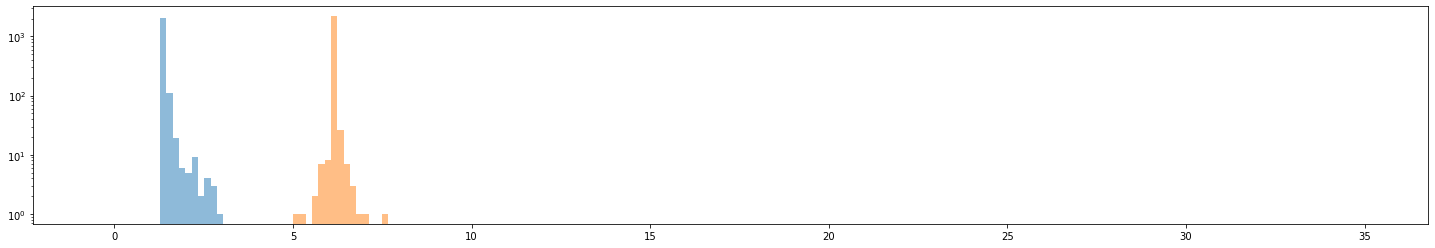

In [70]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==6]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
#plt.hist(energies_model.predict(x[y.reshape(-1)==30]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.show()

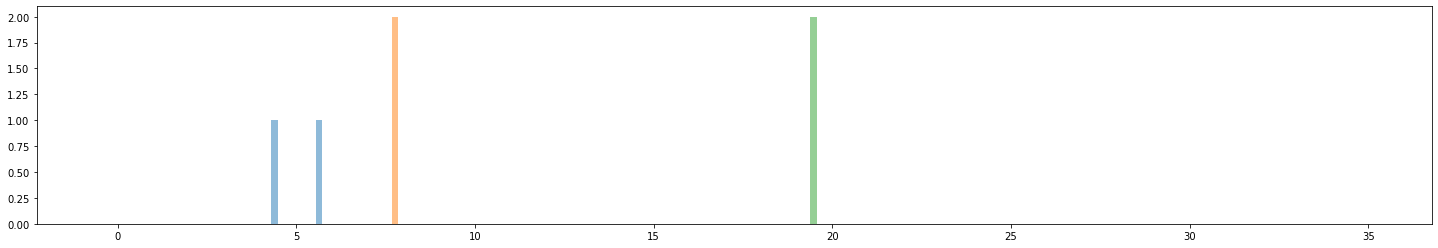

In [71]:
df_t0 = df[df.t==1]
df_t0=df_t0[df_t0.e.isin([3, 10, 30])]

x = np.concatenate([df_t0['spector'].to_numpy().tolist(), df_t0[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
y = df_t0.e.to_numpy().reshape(-1, 1)

plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==3]), bins=200, alpha=0.5, range=(-0.5, 35))
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==10]), bins=200, alpha=0.5, range=(-0.5, 35))
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==30]), bins=200, alpha=0.5, range=(-0.5, 35))
plt.show()

## Используем полученные модели для классификации тестовых данных

In [54]:
df_test = get_test_data(input_shape=(250, 250))
df_test['circular_ratio'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_ratio)(img) for img in tqdm(df_test['img_250'])))
df_test['bright_sum'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_bright_sum)(img) for img in tqdm(df_test['img_250'])))

100%|██████████| 1502/1502 [00:00<00:00, 2189.51it/s]


In [55]:
df_test['id'] = df_test['file_names'].map(lambda file_name: file_name[:-4])

In [56]:
df_test.head()

,file_names,id,img_250,circular_ratio,bright_sum
0,001ec8f4d2679f2899a63e4b2597c0a10bd9393f.png,001ec8f4d2679f2899a63e4b2597c0a10bd9393f,"[[102.0, 103.0, 102.0, 103.0, 101.0, 102.0, 99...",0.895706,10.507998
1,00327390bfd6101b87106e96e0efc1c938690e1f.png,00327390bfd6101b87106e96e0efc1c938690e1f,"[[95.0, 100.0, 99.0, 104.0, 103.0, 101.0, 103....",0.796512,3.450998
2,00573dde8addbac780cfa35a55a790fa1aa45178.png,00573dde8addbac780cfa35a55a790fa1aa45178,"[[102.0, 94.0, 100.0, 102.0, 93.0, 102.0, 99.0...",0.889908,11.896999
3,00cb5b91a4acdfaa2f55dc2266e598ff06f9209e.png,00cb5b91a4acdfaa2f55dc2266e598ff06f9209e,"[[100.0, 100.0, 104.0, 101.0, 102.0, 99.0, 103...",0.823009,3.516998
4,00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2.png,00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2,"[[101.0, 101.0, 99.0, 103.0, 100.0, 105.0, 98....",0.861446,2.985998


In [57]:
np.sum((df_test.circular_ratio<0.8)&(df_test.bright_sum>5))

486

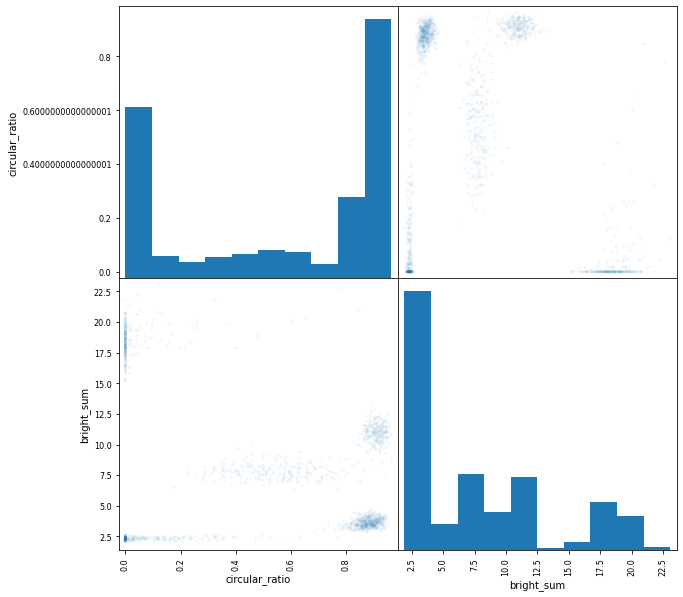

In [58]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_test[['circular_ratio', 'bright_sum']], alpha=0.05, figsize=(10, 10));

In [90]:
df_test['is_center_shifted'] = ((df_test.circular_ratio<0.8)&(df_test.bright_sum>5))

df_test['img_80'] = Parallel(n_jobs=c.NUM_CORES)(delayed(crop_image)(img, (80, 80), False) for img in tqdm(df_test['img_250']))
df_test['img_80'] = df_test['img_80'].map(lambda img: img-np.mean((img[:25]+img[-25:]), axis=0).reshape(1, 80)/2+100.4)
df_test['spector'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(df_test['img_80']))

100%|██████████| 1502/1502 [00:03<00:00, 397.67it/s]


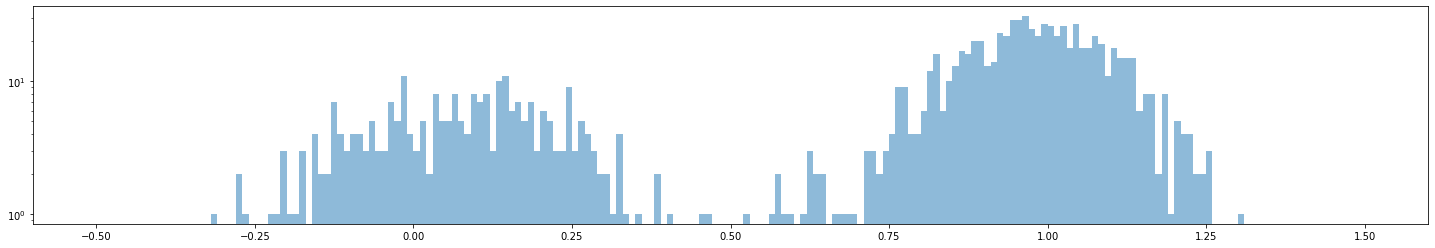

In [91]:
df_test_with_shifted_center = df_test[~df_test['is_center_shifted']]
x = np.concatenate([df_test_with_shifted_center['spector'].to_numpy().tolist(), df_test_with_shifted_center[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)

plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(particle_types_model.predict(x), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

In [92]:
x = np.concatenate([df_test['spector'].to_numpy().tolist(), df_test[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
df_test['particle_types_model'] = particle_types_model.predict(x)

In [93]:
df_test['t'] = ((df_test.is_center_shifted)|(df_test.particle_types_model<0.54))*1

In [94]:
df_test.head()

,file_names,id,img_250,circular_ratio,bright_sum,is_center_shifted,img_80,spector,particle_types_model,t,energies_predict_t0,energies_predict_t1,e
0,001ec8f4d2679f2899a63e4b2597c0a10bd9393f.png,001ec8f4d2679f2899a63e4b2597c0a10bd9393f,"[[102.0, 103.0, 102.0, 103.0, 101.0, 102.0, 99...",0.895706,10.507998,False,"[[103.4, 99.74, 103.020004, 88.48, 96.8, 98.64...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.954150,0,14.718543,19.495340,20
1,00327390bfd6101b87106e96e0efc1c938690e1f.png,00327390bfd6101b87106e96e0efc1c938690e1f,"[[95.0, 100.0, 99.0, 104.0, 103.0, 101.0, 103....",0.796512,3.450998,False,"[[96.48, 102.98, 99.18, 100.840004, 101.74, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.100797,0,3.021856,6.148800,6
2,00573dde8addbac780cfa35a55a790fa1aa45178.png,00573dde8addbac780cfa35a55a790fa1aa45178,"[[102.0, 94.0, 100.0, 102.0, 93.0, 102.0, 99.0...",0.889908,11.896999,False,"[[104.32, 98.26, 103.22, 100.42, 96.1, 107.58,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.944266,0,10.900550,19.478292,20
3,00cb5b91a4acdfaa2f55dc2266e598ff06f9209e.png,00cb5b91a4acdfaa2f55dc2266e598ff06f9209e,"[[100.0, 100.0, 104.0, 101.0, 102.0, 99.0, 103...",0.823009,3.516998,False,"[[97.380005, 100.4, 98.22, 111.18, 96.5, 100.7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.864817,0,3.022061,6.165988,6
4,00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2.png,00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2,"[[101.0, 101.0, 99.0, 103.0, 100.0, 105.0, 98....",0.861446,2.985998,False,"[[99.12, 102.8, 99.42, 107.18, 98.9, 103.56000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.042496,0,3.028168,6.163354,6


In [95]:
x = np.concatenate([df_test['spector'].to_numpy().tolist(), df_test[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
df_test['energies_predict_t0'] = energies_model_t0.predict(x)
df_test['energies_predict_t1'] = energies_model_t1.predict(x)

In [96]:
df_test['e'] = 0
df_test['e'] += ((~df_test.is_center_shifted) & (df_test.t==1) & (0<df_test['energies_predict_t0']) & (df_test['energies_predict_t0']<6)) * 3
df_test['e'] += ((~df_test.is_center_shifted) & (df_test.t==1) & (6<df_test['energies_predict_t0']) & (df_test['energies_predict_t0']<15)) * 10
df_test['e'] += ((~df_test.is_center_shifted) & (df_test.t==1) & (15<df_test['energies_predict_t0']) & (df_test['energies_predict_t0']<30)) * 30

df_test['e'] += ((df_test.t==0) & (0<df_test['energies_predict_t1']) & (df_test['energies_predict_t1']<4)) * 1
df_test['e'] += ((df_test.t==0) & (4<df_test['energies_predict_t1']) & (df_test['energies_predict_t1']<8)) * 6
df_test['e'] += ((df_test.t==0) & (8<df_test['energies_predict_t1'])) * 20

df_test['e'] += (df_test.is_center_shifted & (df_test['bright_sum'] < 12)) * 10
df_test['e'] += (df_test.is_center_shifted & (df_test['bright_sum'] > 12)) * 30

In [97]:
np.sum((df_test.t==0) & (6<df_test['energies_predict_t0']) & (df_test['energies_predict_t0']<15))

182

In [98]:
df_test[df_test.t==0]['energies_predict_t0']

0       14.718543
1        3.021856
2       10.900550
3        3.022061
4        3.028168
          ...    
1489    13.513330
1490     3.020692
1496     3.534946
1499    10.492239
1501     3.246129
Name: energies_predict_t0, Length: 753, dtype: float64

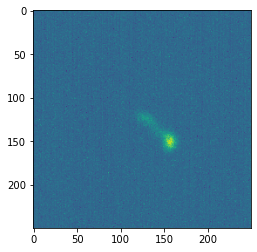

In [99]:
plt.imshow(df_test[(df_test.t==1)].iloc[1].img_250)

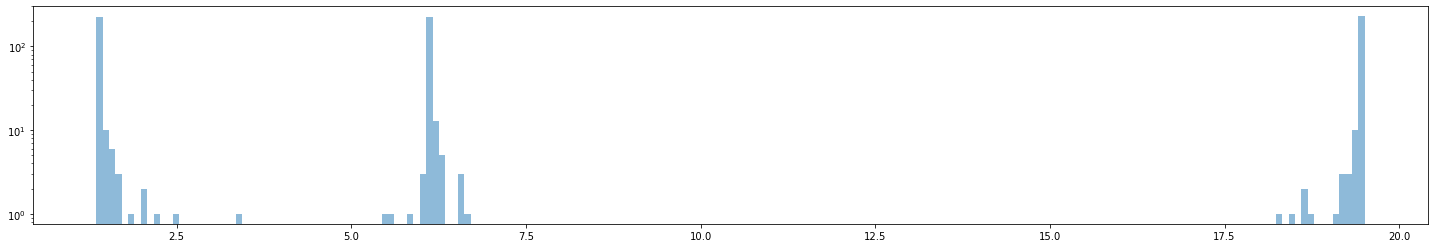

In [100]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(df_test[(df_test.t==0)]['energies_predict_t1'], bins=200, alpha=0.5, log=True)
plt.show()

In [101]:
submission = get_private_test_data()
submission

,file_names,id,classification_predictions,regression_predictions
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96.png,00013a94f1fae3e5a33f8b44c2842c85f0483e96,1,1
1,0005564c011259402dcb6e3beb6e64d285124fa0.png,0005564c011259402dcb6e3beb6e64d285124fa0,1,1
2,0007520c8d8efade8feaafbf74fc7d206cdf229d.png,0007520c8d8efade8feaafbf74fc7d206cdf229d,1,1
3,000804a189f630cd980ff1543c0ef99d48cd6b34.png,000804a189f630cd980ff1543c0ef99d48cd6b34,1,1
4,000eb12def5371089743dcfe401a8e399f5883fc.png,000eb12def5371089743dcfe401a8e399f5883fc,1,1
...,...,...,...,...
15053,ffe6d929d9537cf9b718711a63e41a1b57b509c2.png,ffe6d929d9537cf9b718711a63e41a1b57b509c2,1,1
15054,ffea775cbac98273943841d63b08377d29f08bc7.png,ffea775cbac98273943841d63b08377d29f08bc7,1,1
15055,ffece3dcdcbe2d3125dbed1b8c77f2d6b4832580.png,ffece3dcdcbe2d3125dbed1b8c77f2d6b4832580,1,1
15056,ffed718417c6923844d33e70491c54396e3ec1ed.png,ffed718417c6923844d33e70491c54396e3ec1ed,1,1


In [102]:
submission = pd.concat([submission, df_test])#pd.merge(submission, df_test, how="outer", on=['id'])
submission = submission.fillna(1, axis=0)

In [103]:
submission = submission[['id', 't', 'e']]
submission.t = submission.t.astype(int)
submission.e = submission.e.astype(int)
submission = submission.rename(columns={"t": "classification_predictions", "e": "regression_predictions"})

In [104]:
submission.to_csv('submission.csv', index=False)

In [89]:
submission

,id,classification_predictions,regression_predictions
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96,1,1
1,0005564c011259402dcb6e3beb6e64d285124fa0,1,1
2,0007520c8d8efade8feaafbf74fc7d206cdf229d,1,1
3,000804a189f630cd980ff1543c0ef99d48cd6b34,1,1
4,000eb12def5371089743dcfe401a8e399f5883fc,1,1
...,...,...,...
1497,ff343a62752061d995f94ebc10ac53f79d1b5ab1,1,3
1498,ff897755cb312cd6f510ba7a38cb293e648d97d5,1,3
1499,ff9a93402457ac514cd069a7ce3f2e32692f5290,0,20
1500,ffedc12ec5c142dae2086408b778cf0db2ff944e,1,3
